# How PyTorch works under the hood.

In this notebook, we’ll implement a simplified version of PyTorch. Our goal today is to build our own autograd engine capable of calculating the gradient of `any` function. 

Sounds complex? 

Don’t worry, I’ll guide you through the process!

------

Let’s begin our discussion on how to calculate the gradient or `backward` method. 

Consider a function $F: \mathbb{R}^{D} \rightarrow \mathbb{R} $ that is a composition of four primitive functions, expressed as ( $F = D \circ C \circ B \circ A $). We can break down the function as follows:

$F(x) = y$

$F(x) = y$

$y = D(c)$

$c = C(b)$

$b = B(a)$

$a = A(x)$

Where the individual derivatives are defined as follows:


$F'(x) = \frac{\partial y}{\partial x} = \frac{\partial y}{\partial c} \frac{\partial c}{\partial b}  \frac{\partial b}{\partial a}  \frac{\partial a}{\partial x} $

where: 

$ \frac{\partial y}{\partial c} = D'(c),  \frac{\partial c}{\partial b} = C'(b),  \frac{\partial b}{\partial a} = B'(a),  \frac{\partial a}{\partial x} = A'(x)$ 


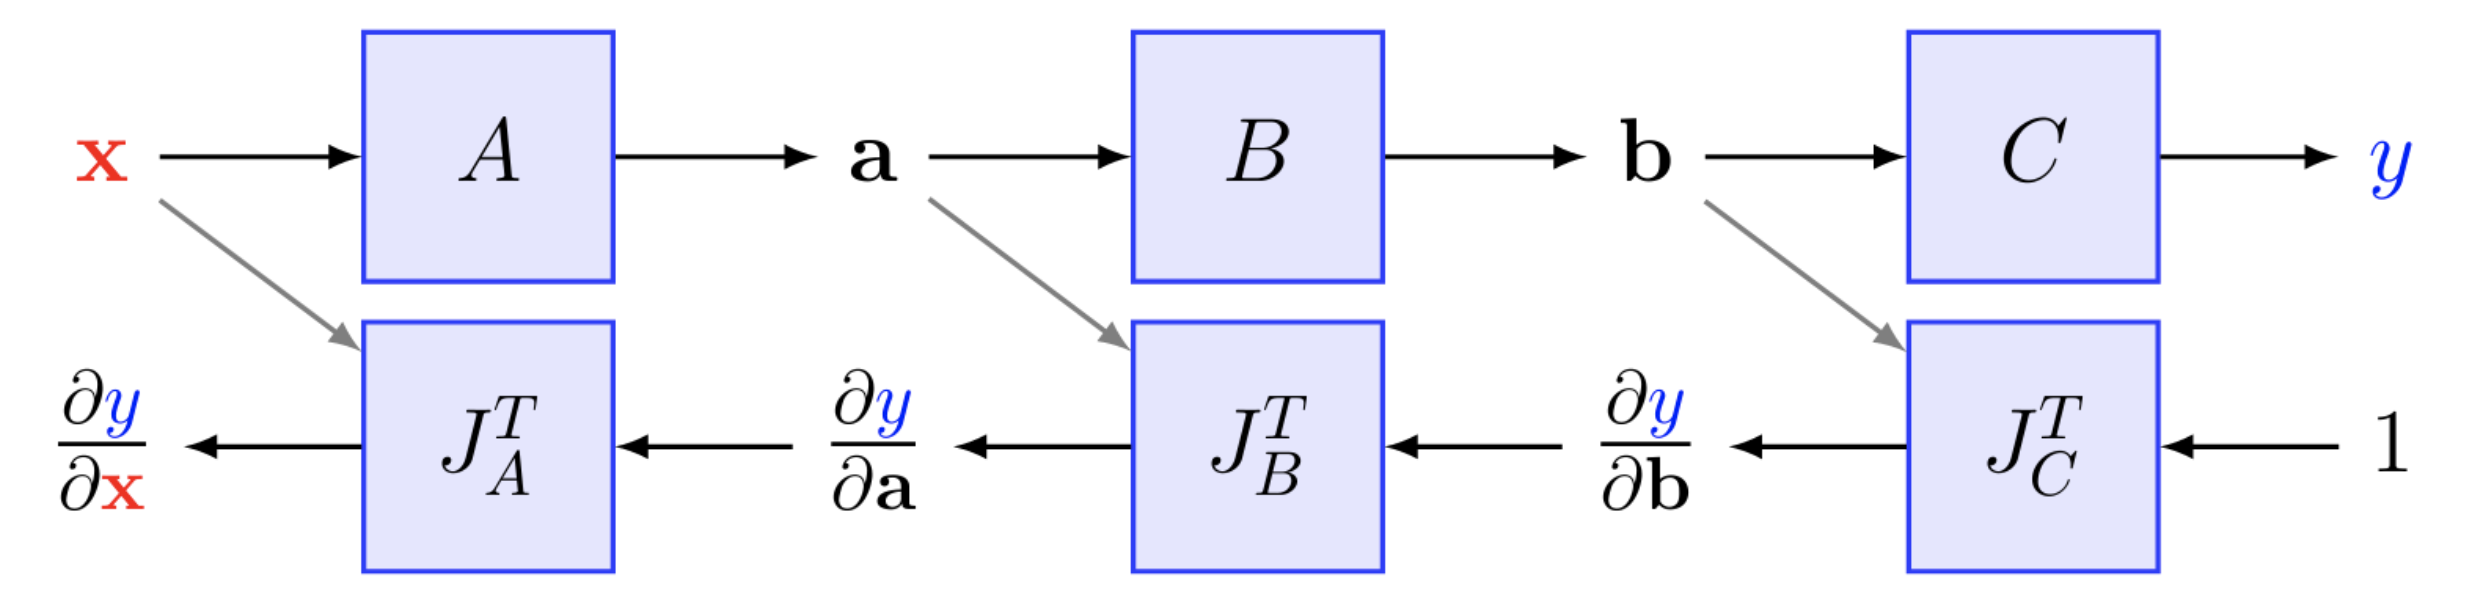


# Let's build a computation graph! 

Each primitive function is replaced with a wrapped version that handles bookkeeping.
* The wrapping layer records:
  * The function name
  * The arguments
  * The return value
* Wrapped functions behave like the original functions.
* Return values from primitive function calls are encapsulated in `Variable` objects, representing nodes in the computation graph.

Each Node contains:

* Its underlying value
* The function that created it
* A list of parent `Variable` (the arguments passed)


When a wrapped function is called:
* It unboxes any `Variable` arguments.
* It invokes the underlying primitive function.
* It boxes the return value as a new `Variable` (only if necessary for performance).

This process allows tracing the genealogy of each `Variable`, forming a dynamic computation graph that reflects the history of how its value was computed.


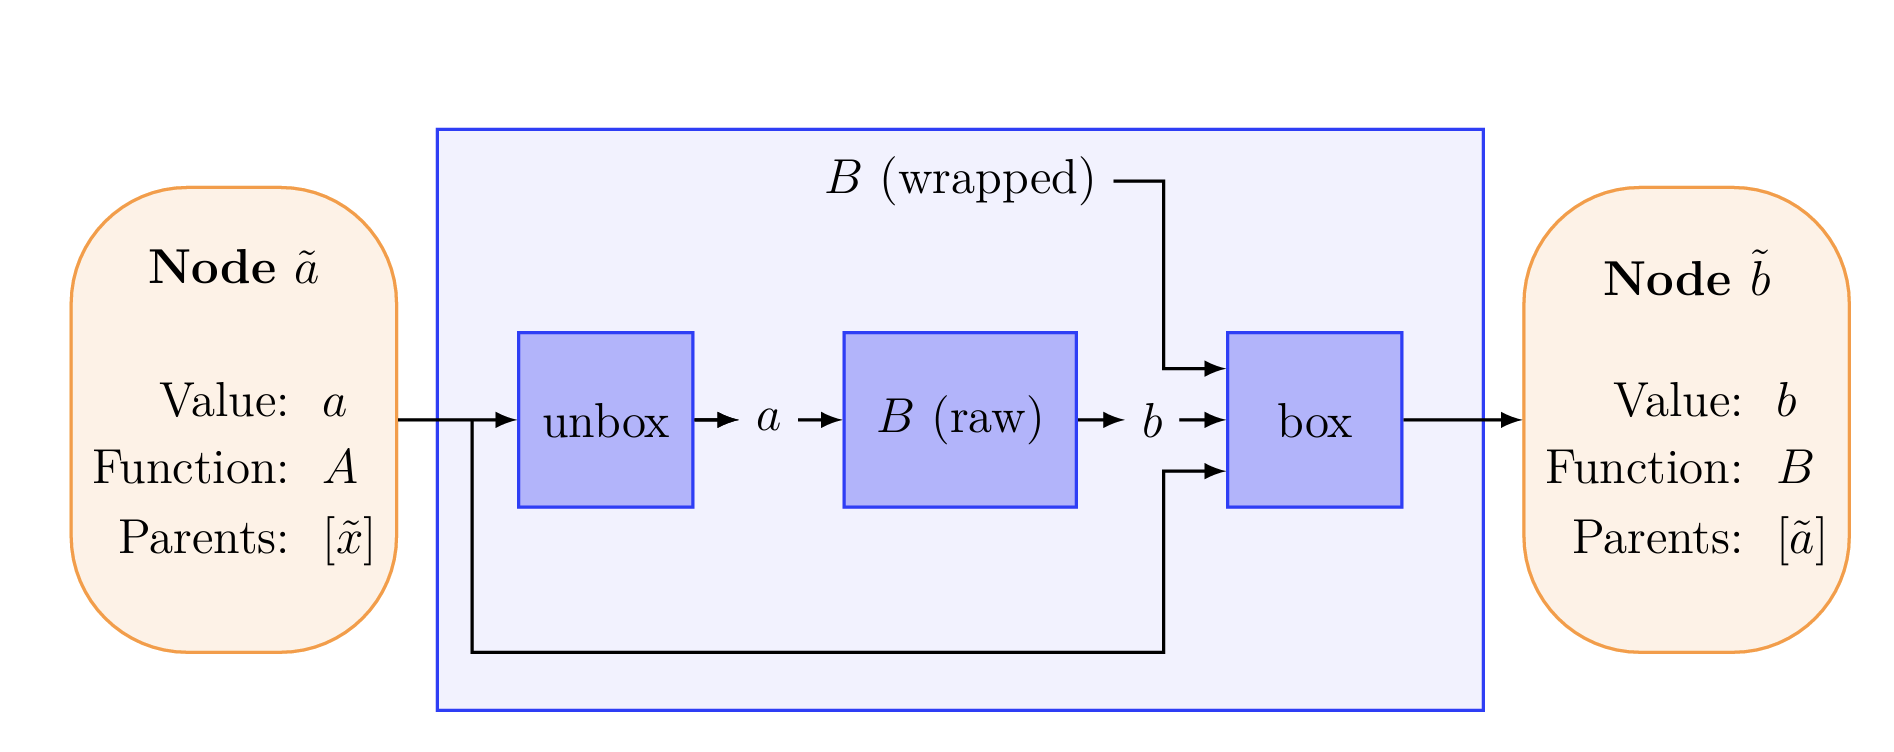



In [30]:
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
from typing import Callable, List, Optional, Union
from graphviz import Digraph



In [31]:
@dataclass
class Variable:
    """
    Represents a node in a computational graph.

    Attributes:
        value (Union[None, float, int, np.ndarray]): The value of the variable.
        parents (List[Variable]): A list of parent nodes in the computational graph.
        fun (Optional[Callable]): The function that generated this variable if it's an inner node.
        name (Optional[str]): An optional name for the variable.
        args (Optional[Union[float, int]]): Additional arguments for the function, if any.
        grad (float): The gradient of the variable.
        is_leaf (bool): Indicates if the variable is a leaf node.
        preserve (bool): If True, the variable's value will be preserved during deletion.
    """
    value: Union[None, float, int, np.ndarray] = None
    parents: List = None
    fun: Optional[Callable] = None
    name: Optional[str] = None
    args: Optional[Union[float, int]] = None
    grad: float = 0.0
    is_leaf: bool = False
    preserve: bool = False

    def __init__(self, value = None, parents = [], fun = None, name = None, args = None, grad = 0.0, is_leaf = False, preserve = False):
        self.value = value
        self.parents = parents
        self.fun = fun
        self.name = name
        self.args = args
        self.grad = grad
        self.preserve = preserve

        self.__post_init__()

    def __hash__(self):
        return hash((self.value, self.fun))
        

    def __post_init__(self):
        if self.value is not None:
            self._init_if_leaf(self.value)
        else:
            self._init_as_inner_node(self.parents, self.fun, self.args)

    def _init_if_leaf(self, value):
        """Initialize the variable as a leaf node."""
        self.value = value
        self.is_leaf = True
        
    def __del__(self):
        """Clean up resources when the variable is deleted."""
        if not self.preserve:
            del self.value
            del self.fun
            del self.args
            del self.grad
            del self.name
            self.parents.clear()

    def _init_as_inner_node(self, parents, fun, args=None):
        if args is None:
            self.value = fun(*list(map(lambda x: x.value, parents)))
        else:
            fun_params = list(map(lambda x: x.value, parents))
            fun_params.append(args)
            self.value = fun(*fun_params)

        self.fun = fun
        self.args = args
        self.is_leaf = False
        self.parents = parents
        self.grad = 0

    def backward(self):
        sorted_nodes = topological_sort(self)
        backward(sorted_nodes)
        cleanup_graph(sorted_nodes)


    def shape(self):
        """Return the shape of the variable's value."""
        if isinstance(self.value, (int, float)):
            return (1,)
        else:
            return self.value.shape

    def _single_operator(self, fun, args=None):
        """Create a new Variable resulting from applying a single operator."""
        return Variable(parents=[self], fun=fun, args=args)

    def _two_variable_operator(self, other, fun, args=None):
        """Create a new Variable resulting from applying a two-variable operator."""
        if not isinstance(other, Variable):
            other = Variable(other)
        return Variable(parents=[self, other], fun=fun, args=args)

    def __add__(self, other):
        return self._two_variable_operator(other, lambda x,y: np.add(x, y))

    def __mul__(self, other):
        return self._two_variable_operator(other, lambda x,y: np.multiply(x,y))

    def __radd__(self, other):
        return self._two_variable_operator(other, lambda x,y: np.add(y, x))

    
    def __rmul__(self, other):
        return self._two_variable_operator(other, lambda x,y: np.multiply(y, x))

    
    @classmethod
    def log(cls, variable):
        return Variable._single_operator(variable, lambda x: np.log(x))



In [32]:
def backward(sorted_nodes):
    """
    Performs backpropagation through the computational graph to compute gradients.

    This function iterates through the nodes in reverse order, starting from the output node,
    and calculates the gradients for each node based on its parents and the associated 
    primitive functions. The gradients are accumulated in each parent node.

    Args:
        sorted_nodes (List[Variable]): A list of nodes in the computational graph,
                                        sorted in reverse topological order.

    Returns:
        None: The gradients are stored in the `grad` attribute of each parent node.

    Notes:
        - The gradient of the first node is initialized to 1, representing the derivative of the 
          output with respect to itself.
        - The method handles nodes with one or two parents and applies necessary broadcasting 
          to ensure gradient shapes are compatible.
        - The function extracts the name of the primitive function associated with each node 
          for gradient computation.
    """
    
    def get_function_name(fun):
        # This is the easiest way of extracting function name, and finding associated primitive in the dictionary.
        return str(fun).split(".")[1]

    def reverse_broadcasting(node, gradient):
        if len(node.shape()) < len(gradient.shape()):
            # print("reverse broadcast", node.shape(), gradient.shape())
            gradient = Variable.sum(gradient, axis=0)
            # print("reversed: ",gradient.shape() )
        return gradient

    sorted_nodes[0].grad = Variable(1)
    for node in sorted_nodes:
        if node.fun is None:
            continue
        # print("processing node", node)

        primitive_function = primitives[get_function_name(node.fun)]
        # right now, there are 2 options. Each node has two or one parent(s).
        # no option to have more than 2, since e.g. a+b+c will be converted into two nodes (a+b) + c
        if len(node.parents) == 2:
            # gradient with respect to one parent or with respect to another makes a difference.
            # thus we need to treat them separately.
            parent_left, parent_right = node.parents
            left_update = primitive_function[0](node.grad, parent_left, parent_right, node.args)
            # print("left update", left_update)
            parent_left.grad += left_update
            parent_left.grad = reverse_broadcasting(parent_left, parent_left.grad)

            right_update = primitive_function[1](node.grad, parent_left, parent_right, node.args)
            # print("right_update update", right_update)
            parent_right.grad += right_update
            parent_right.grad = reverse_broadcasting(parent_right, parent_right.grad)

        else:
            parent = node.parents[0]
            update = primitive_function(node.grad, parent, node.args)

            # print("parent grad update", update)
            parent.grad += update
            parent.grad = reverse_broadcasting(parent, parent.grad)


In [33]:
def draw_graph(node):
    """
    Visualizes the structure of a computational graph.

    This function creates a graphical representation of the computational graph,
    showing the relationships between nodes and their parent nodes. Leaf nodes 
    are represented with their values, while inner nodes display the name of 
    the function that created them.

    Args:
        node (Variable): 
            The root node of the computational graph to visualize.

    Returns:
        graphviz.dot.Digraph: 
            A Graphviz Digraph object representing the computational graph.

    Notes:
        - Leaf nodes are displayed with a light blue background.
        - The graph is constructed recursively, traversing parent nodes to 
          capture the entire structure of the graph.
    """
    node_attr = dict(style='filled',
                     shape='box',
                     align='left',
                     fontsize='12',
                     ranksep='0.1',
                     height='0.2')
    dot = Digraph(node_attr=node_attr, graph_attr=dict(size="12,12"))
    seen = set()

    def add_node(node):
        if node in seen:
            return

        if node.is_leaf:
            dot.node(str(id(node)), str(node.value), fillcolor='lightblue')
        else:
            fun_name = str(node.fun).split(".")[1]
            dot.node(str(id(node)), fun_name)

        seen.add(node)
        for parent in node.parents:
            dot.edge(str(id(parent)), str(id(node)))
            add_node(parent)

    add_node(node)
    return dot


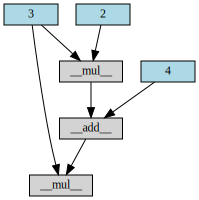

In [39]:
x = Variable(3)
y = x * 2
z = y + 4
w = z * x

draw_graph(w)

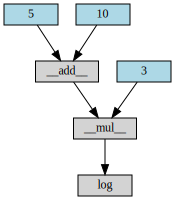

In [ ]:
a = Variable(5)
b = a + 10
c = b * 3
d = Variable.log(c)

draw_graph(d)


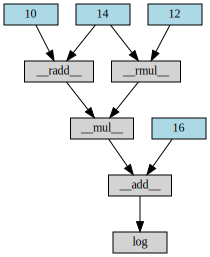

In [44]:

v = Variable(14)
v_add = 10 + v
v_mul = 12 * v
v_result = v_add * v_mul + 16
v_final = Variable.log(v_result)
draw_graph(v_final)

In [38]:
def sum_backward(grad, x, axis):
    """
    Implements the backward pass for a sum operation.

    This function handles two scenarios:
    1. When summing over all dimensions (e.g., `sum([[1, 2], [3, 4]]) = 10`).
       In this case, the function returns the gradient from the previous step 
       (a single number) multiplied by a tensor that matches the shape of the input tensor.
       
    2. When the user specifies an axis (or axes) for summation (e.g., 
       `sum([[1, 2], [3, 4]], axis=0) = [4, 6]`).
       Here, the function broadcasts the result to match the shape of the input tensor.

    TODO: Add figures to visualize these concepts.

    Args:
        grad (Variable): The gradient from the previous step.
        x (Variable): The input tensor for which the backward pass is being computed.
        axis (Optional[Union[int, List[int]]]): The axis or axes along which to sum. 
            If None, sums over all dimensions.

    Returns:
        Variable: The computed gradient for the input tensor.
    """
    if axis is None:
        return grad*np.ones_like(x.value)
    return Variable(np.broadcast_to(grad.value, x.shape()[::-1]).T)


def mean_backward(grad, x, axis):
    """
    Implements the backward pass for a mean operation.

    This function calculates the gradient of the mean. 
    Currently, the `axis` parameter is not supported and will raise an error if specified.

    Args:
        grad (Variable): The gradient from the previous step.
        x (Variable): The input tensor for which the backward pass is being computed.
        axis (Optional[Union[int, List[int]]]): The axis or axes along which to compute the mean. 
            This parameter is not supported and will raise a NotImplementedError if provided.

    Returns:
        Variable: The computed gradient for the input tensor, scaled by the normalization factor.
    
    Raises:
        NotImplementedError: If the `axis` parameter is specified.
    """
    def find_normalization_factor(shape):
        return reduce(lambda x, y: x * y, shape)

    if axis is not None:
        raise NotImplementedError
    return grad.value / find_normalization_factor(x.shape()) * Variable(np.ones_like(x))



primitives = {"__add__": [lambda grad, left, right, args: grad] * 2,
              "__radd__": [lambda grad, left, right, args: grad] * 2,

              "__mul__": # implement me

              "__sub__": #implement me

              "__rsub__": #implement me

              "__truediv__": #implement me
              # based on https://math.stackexchange.com/a/3850121
              "__matmul__": [lambda grad, left, right, args: grad @ Variable.transpose(right),
                             lambda grad, left, right, args: Variable.transpose(left) @ grad
                             ],
              "sin": #implement me
              "cos": #implement me
              "log": #implement me
              "relu": #implement me
              "sigmoid": #implement me
              "sum": #implement me
              "mean": #implement me
              "exp": #implement me
              "transpose": #implement me
              "clip_min": #implement me
              "abs": #implement me
              "sign": #implement me
              }

SyntaxError: invalid syntax (1598429741.py, line 63)

# Taks

1. Add unit tests to make sure it works vs pytorch
2. Check the  

# Utility funcitons taht you may find usefull! 

In [ ]:
def plot_function_and_derivative(fun, range=[0,1], n_points=100):

  def evaluate_derivative(x, fun):
    x_var = Variable(x)
    y = fun(x_var)
    y.backward()
    return y.value, x_var.grad.value

  x_points = np.linspace(start = range[0], stop=range[1], num=n_points)
  y = np.transpose(np.array(list(map(lambda x: evaluate_derivative(x, fun), x_points))))
  plt.plot(x_points, y[0], color='blue', label="function")
  plt.plot(x_points, y[1], color='red', linestyle='dashed', label="derivative")
